In [706]:
#  Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [707]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [708]:
!pip install arabic-reshaper python-bidi
!pip install xgboost


# **DATA**

In [709]:

file_path = '/content/drive/MyDrive/SmartServicePriorityModelproject/بلاغات (1).xlsx'
df=pd.read_excel(file_path)
df.head(20)


,رقم البلاغ,نوع الخدمة,حالة البلاغ,تاريخ البلاغ,البلدية,عدد السكان,موقع البلاغ,عدد تكرار البلاغ
0,5001,تسوير المباني,مكتمل,2025-08-20 03:00,بلدية الشرائع الفرعية,88000,حي الريان,2
1,5002,الحواجز الخرسانية,مكتمل,2025-08-09 18:00,بلدية بحرة الفرعية,45000,بحرة المجاهدين,3
2,5003,سيارات تالفة,تم الحل,2025-05-16 07:00,بلدية العزيزية الفرعية,95000,شارع العزيزية,6
3,5004,تسوير المباني,مكتمل,2025-05-19 13:00,بلدية المركزية الفرعية,110000,حي الهجلة,1
4,5005,مخلفات البناء,تم الحل,2025-07-01 16:00,بلدية الشرائع الفرعية,88000,حي الشرائع,7
5,5006,تغليف المباني,تم الحل,2025-06-04 05:00,بلدية المعابدة الفرعية,66000,شارع ثبير,2
6,5007,تغليف المباني,قيد المعالجة,2025-05-22 00:00,بلدية العمرة الفرعية,72000,حي النوارية,1
7,5008,تغليف المباني,قيد التنفيذ,2025-07-23 20:00,بلدية العزيزية الفرعية,95000,شارع العزيزية,1
8,5009,الحواجز الخرسانية,بانتظار التفتيش,2025-07-07 20:00,بلدية العزيزية الفرعية,95000,حي العوالي,7
9,5010,سيارات تالفة,مكتمل,2025-08-20 02:00,بلدية العمرة الفرعية,72000,حي النوارية,0


In [710]:
df.shape

(10000, 8)

In [711]:
# check if there is a missing value
df.isnull().sum()

,0
رقم البلاغ,0
نوع الخدمة,0
حالة البلاغ,0
تاريخ البلاغ,0
البلدية,0
عدد السكان,0
موقع البلاغ,0
عدد تكرار البلاغ,0


In [712]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [713]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers


In [714]:
outliers = detect_outliers_iqr(df, 'عدد السكان')
print(f"عدد القيم الشاذة: {len(outliers)}")

outliers = detect_outliers_iqr(df, 'عدد تكرار البلاغ')
print(f"عدد القيم الشاذة: {len(outliers)}")


عدد القيم الشاذة: 0
عدد القيم الشاذة: 0


In [715]:
df.dtypes

,0
رقم البلاغ,int64
نوع الخدمة,object
حالة البلاغ,object
تاريخ البلاغ,object
البلدية,object
عدد السكان,int64
موقع البلاغ,object
عدد تكرار البلاغ,int64


In [716]:
df['تاريخ البلاغ'] = pd.to_datetime(df['تاريخ البلاغ'], errors='coerce')

In [717]:
df.dtypes

,0
رقم البلاغ,int64
نوع الخدمة,object
حالة البلاغ,object
تاريخ البلاغ,datetime64[ns]
البلدية,object
عدد السكان,int64
موقع البلاغ,object
عدد تكرار البلاغ,int64


In [718]:
df = df.rename(columns={'عدد تكرار البلاغ':'عدد البلاغات'})

In [719]:
df.head(5)

,رقم البلاغ,نوع الخدمة,حالة البلاغ,تاريخ البلاغ,البلدية,عدد السكان,موقع البلاغ,عدد البلاغات
0,5001,تسوير المباني,مكتمل,2025-08-20 03:00:00,بلدية الشرائع الفرعية,88000,حي الريان,2
1,5002,الحواجز الخرسانية,مكتمل,2025-08-09 18:00:00,بلدية بحرة الفرعية,45000,بحرة المجاهدين,3
2,5003,سيارات تالفة,تم الحل,2025-05-16 07:00:00,بلدية العزيزية الفرعية,95000,شارع العزيزية,6
3,5004,تسوير المباني,مكتمل,2025-05-19 13:00:00,بلدية المركزية الفرعية,110000,حي الهجلة,1
4,5005,مخلفات البناء,تم الحل,2025-07-01 16:00:00,بلدية الشرائع الفرعية,88000,حي الشرائع,7


In [720]:
# استعراض كل الأعمدة من نوع نصي
text_columns = df.select_dtypes(include='object').columns

# طباعة القيم الفريدة في كل عمود نصي
for col in text_columns:
    df[col] = df[col].str.strip() # حذف المسافات
    print(f"\n--- {col} ---")
    print(df[col].unique())



--- نوع الخدمة ---
['تسوير المباني' 'الحواجز الخرسانية' 'سيارات تالفة' 'مخلفات البناء'
 'تغليف المباني' 'أعمدة إنارة']

--- حالة البلاغ ---
['مكتمل' 'تم الحل' 'قيد المعالجة' 'قيد التنفيذ' 'بانتظار التفتيش'
 'تم الإغلاق' 'بانتظار الإسناد' 'غير موجود على الطبيعة']

--- البلدية ---
['بلدية الشرائع الفرعية' 'بلدية بحرة الفرعية' 'بلدية العزيزية الفرعية'
 'بلدية المركزية الفرعية' 'بلدية المعابدة الفرعية' 'بلدية العمرة الفرعية'
 'بلدية الشوقية الفرعية' 'بلدية الجموم']

--- موقع البلاغ ---
['حي الريان' 'بحرة المجاهدين' 'شارع العزيزية' 'حي الهجلة' 'حي الشرائع'
 'شارع ثبير' 'حي النوارية' 'حي العوالي' 'حي جبل النور' 'حي الكعكية'
 'حي التنعيم' 'حي السلام' 'شارع الحج' 'منطقة الحرم' 'حي الغزالي'
 'حي الشوقية' 'حي حداء' 'شارع الليث' 'حي الخنساء' 'شارع عمر بن الخطاب'
 'شارع أجياد' 'شارع بحرة العام' 'شارع النورية' 'حي الهجرة']


In [721]:
# خريطة ربط كل نوع خدمة بدرجة الخطورة
danger_map = {
    'تغليف المباني': 1,
    'تسوير المباني': 2,
    'الحواجز الخرسانية': 3,
    'سيارات تالفة': 4,
    'مخلفات البناء': 5,
    'أعمدة إنارة': 6
}

# إضافة العمود الجديد بناءً على نوع الخدمة
df['درجة الخطورة'] = df['نوع الخدمة'].map(danger_map)


In [722]:
# استعراض بعض الصفوف
df[['نوع الخدمة', 'درجة الخطورة']].head(5)

,نوع الخدمة,درجة الخطورة
0,تسوير المباني,2
1,الحواجز الخرسانية,3
2,سيارات تالفة,4
3,تسوير المباني,2
4,مخلفات البناء,5


In [723]:
# المجموعة الأولى: أحياء سكنية تشهد مشاريع تطويرية
group1_locations = [
    'حي الريان', 'حي الشرائع', 'حي النوارية', 'حي العوالي', 'حي الكعكية',
    'حي التنعيم', 'حي الهجلة', 'حي الهجرة'
]
group1_classification = 'مشاريع سكنية'

# المجموعة الثانية: محاور طرق ومناطق مركزية تشهد تطويرًا شاملًا
group2_locations = [
    'شارع العزيزية', 'شارع الحج', 'منطقة الحرم', 'شارع أجياد'
]
group2_classification = 'محور إستراتيجي'

# المجموعة الثالثة: مناطق ذات مشاريع نوعية أو أقل وضوحًا في التفاصيل
# هذه ستشمل جميع المواقع الأخرى التي لم تدرج في المجموعتين 1 و 2
group3_locations = [
    'بحرة المجاهدين', 'شارع ثبير', 'حي جبل النور', 'حي السلام', 'حي الغزالي',
    'حي الشوقية', 'حي حداء', 'شارع الليث', 'حي الخنساء', 'شارع عمر بن الخطاب',
    'شارع بحرة العام', 'شارع النورية'
]
group3_classification = 'غير محدد'

# 3. إنشاء دالة لتطبيق التصنيف
def classify_site_attribute(location):
    if location in group1_locations:
        return group1_classification
    elif location in group2_locations:
        return group2_classification
    elif location in group3_locations:
        return group3_classification
    else:
        # حالة احتياطية لأي موقع غير موجود في القوائم المحددة
        return 'تصنيف غير معروف'

df['صفة الموقع'] = df['موقع البلاغ'].apply(classify_site_attribute)


In [724]:
df.head(5)

,رقم البلاغ,نوع الخدمة,حالة البلاغ,تاريخ البلاغ,البلدية,عدد السكان,موقع البلاغ,عدد البلاغات,درجة الخطورة,صفة الموقع
0,5001,تسوير المباني,مكتمل,2025-08-20 03:00:00,بلدية الشرائع الفرعية,88000,حي الريان,2,2,مشاريع سكنية
1,5002,الحواجز الخرسانية,مكتمل,2025-08-09 18:00:00,بلدية بحرة الفرعية,45000,بحرة المجاهدين,3,3,غير محدد
2,5003,سيارات تالفة,تم الحل,2025-05-16 07:00:00,بلدية العزيزية الفرعية,95000,شارع العزيزية,6,4,محور إستراتيجي
3,5004,تسوير المباني,مكتمل,2025-05-19 13:00:00,بلدية المركزية الفرعية,110000,حي الهجلة,1,2,مشاريع سكنية
4,5005,مخلفات البناء,تم الحل,2025-07-01 16:00:00,بلدية الشرائع الفرعية,88000,حي الشرائع,7,5,مشاريع سكنية


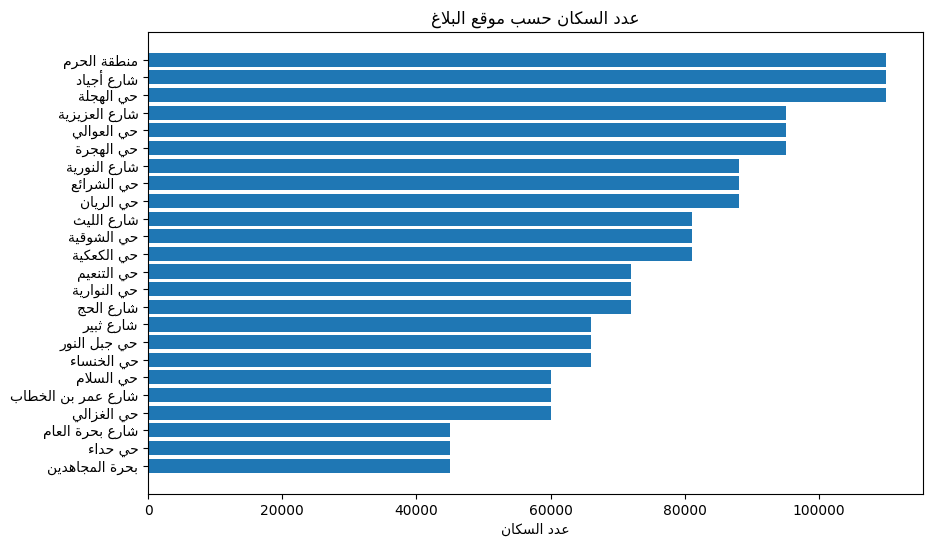

In [725]:
grouped = df.groupby('موقع البلاغ')['عدد السكان'].mean().sort_values()
labels = grouped.index
labels_fixed = [get_display(arabic_reshaper.reshape(label)) for label in labels]
values = grouped.values

plt.figure(figsize=(10, 6))
plt.barh(labels_fixed, values)
plt.title(get_display(arabic_reshaper.reshape('عدد السكان حسب موقع البلاغ')))
plt.xlabel(get_display(arabic_reshaper.reshape('عدد السكان')))
plt.show()


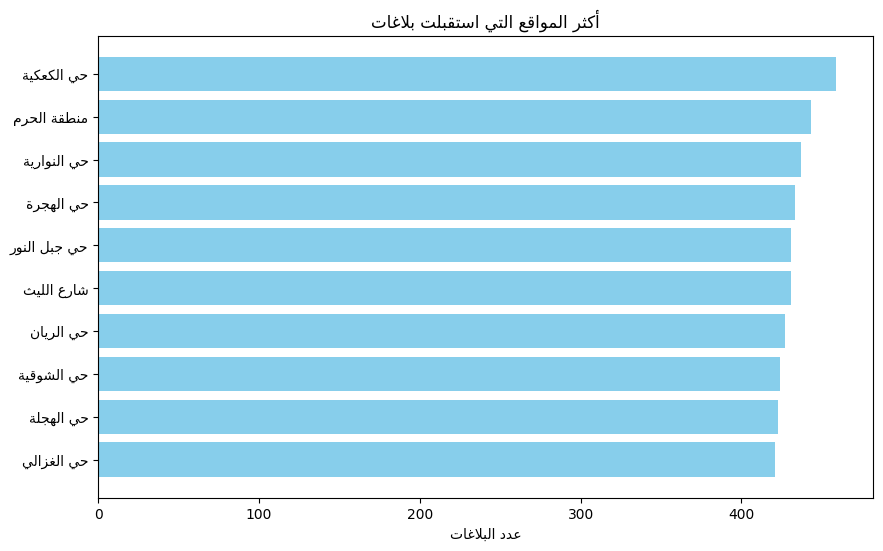

In [726]:
top_sites = df['موقع البلاغ'].value_counts().head(10)

# إصلاح الخط
labels = [get_display(arabic_reshaper.reshape(i)) for i in top_sites.index]
values = top_sites.values

plt.figure(figsize=(10,6))
plt.barh(labels, values, color='skyblue')
plt.title(get_display(arabic_reshaper.reshape('أكثر المواقع التي استقبلت بلاغات')))
plt.xlabel(get_display(arabic_reshaper.reshape('عدد البلاغات')))
plt.gca().invert_yaxis()
plt.show()


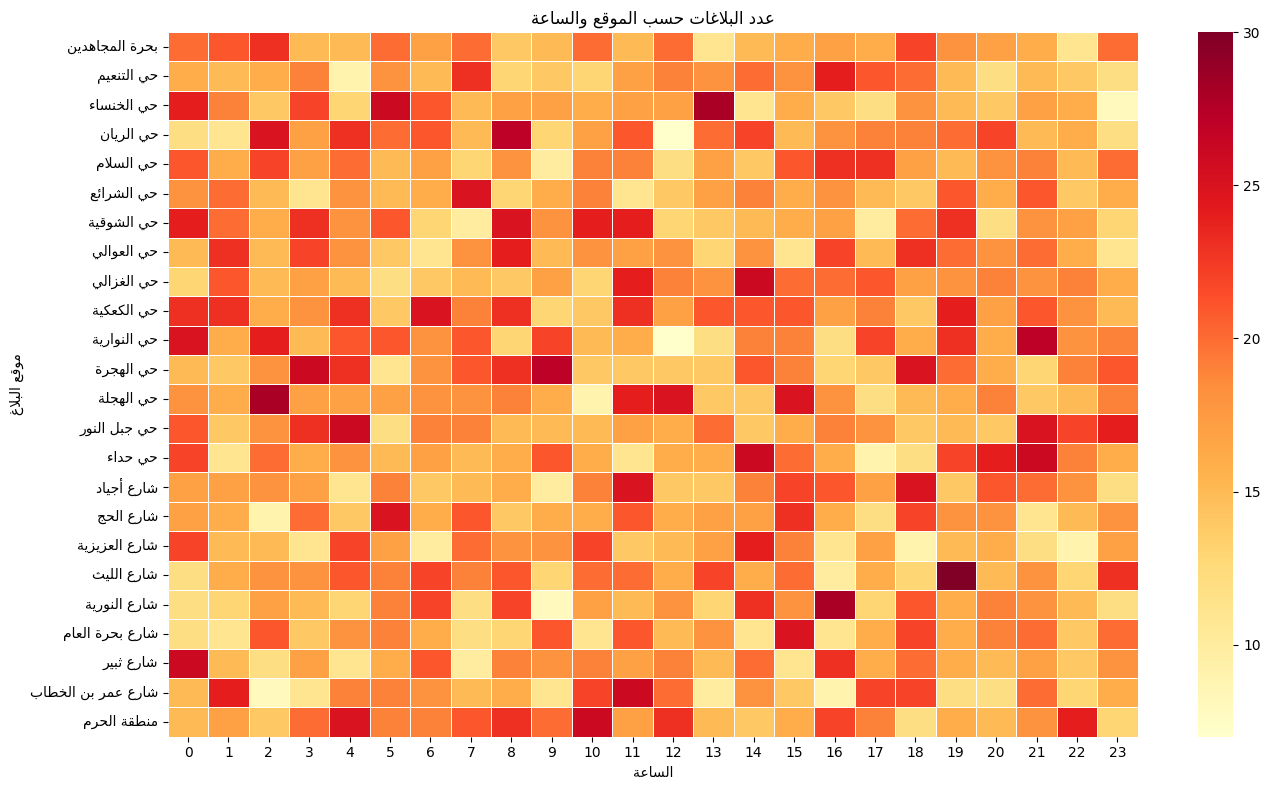

In [727]:
# إنشاء نسخة مؤقتة فقط للرسم
df_temp = df.copy()

# استخراج الساعة من عمود التاريخ
df_temp['الساعة'] = pd.to_datetime(df_temp['تاريخ البلاغ']).dt.hour

# تجميع البيانات حسب موقع البلاغ والساعة
grouped = df_temp.groupby(['موقع البلاغ', 'الساعة']).size().unstack(fill_value=0)

# إصلاح النص العربي للعرض
grouped.index = [get_display(arabic_reshaper.reshape(txt)) for txt in grouped.index]
grouped.columns = [str(col) for col in grouped.columns]  # تأكد أن الأعمدة نصوص (الساعات)

# رسم خريطة حرارية
plt.figure(figsize=(14, 8))
sns.heatmap(grouped, cmap="YlOrRd", linewidths=.5)

plt.title(get_display(arabic_reshaper.reshape('عدد البلاغات حسب الموقع والساعة')))
plt.xlabel(get_display(arabic_reshaper.reshape('الساعة')))
plt.ylabel(get_display(arabic_reshaper.reshape('موقع البلاغ')))
plt.tight_layout()
plt.show()


/tmp/ipython-input-728-95350278.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="صفة الموقع", y="عدد البلاغات", data=grouped, palette="YlOrBr")


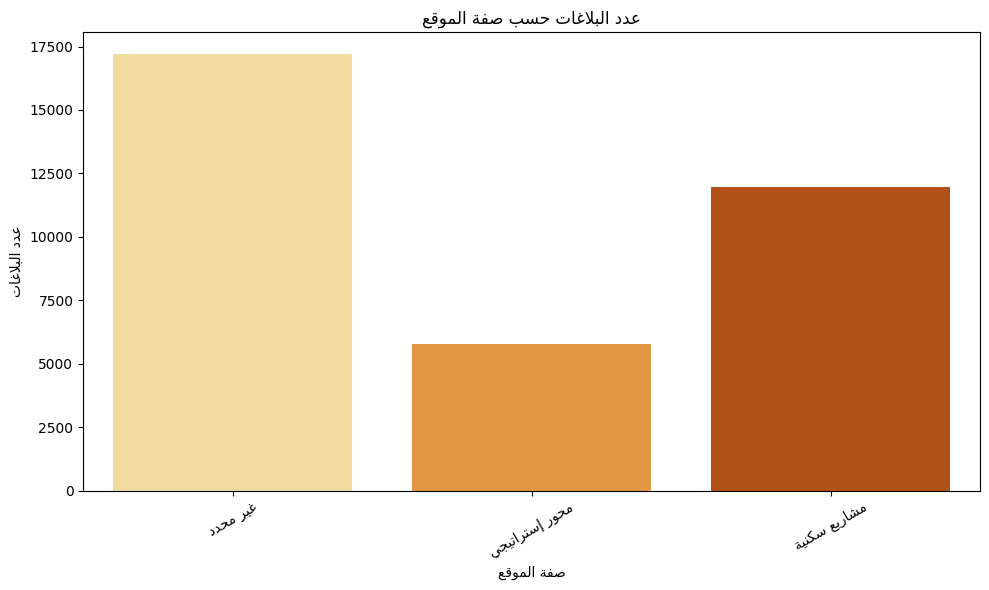

In [728]:
grouped = df.groupby("صفة الموقع")["عدد البلاغات"].sum().reset_index()

# إصلاح النص العربي
grouped["صفة الموقع"] = [get_display(arabic_reshaper.reshape(txt)) for txt in grouped["صفة الموقع"]]

# رسم المخطط
plt.figure(figsize=(10, 6))
sns.barplot(x="صفة الموقع", y="عدد البلاغات", data=grouped, palette="YlOrBr")

plt.title(get_display(arabic_reshaper.reshape("عدد البلاغات حسب صفة الموقع")))
plt.xlabel(get_display(arabic_reshaper.reshape("صفة الموقع")))
plt.ylabel(get_display(arabic_reshaper.reshape("عدد البلاغات")))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [729]:
# تحديد الأعمدة النصية فقط
text_cols = df.select_dtypes(include='object').columns

# تخزين الـ encoders في حال احتجتِ فك التشفير لاحقًا
encoders = {}

# تطبيق التشفير على كل عمود نصي داخل df مباشرة
for col in text_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # التأكد من كون القيم نصوص
    encoders[col] = le

In [730]:
df.head(5)

,رقم البلاغ,نوع الخدمة,حالة البلاغ,تاريخ البلاغ,البلدية,عدد السكان,موقع البلاغ,عدد البلاغات,درجة الخطورة,صفة الموقع
0,5001,2,7,2025-08-20 03:00:00,1,88000,3,2,2,2
1,5002,1,7,2025-08-09 18:00:00,7,45000,0,3,3,0
2,5003,4,3,2025-05-16 07:00:00,3,95000,17,6,4,1
3,5004,2,7,2025-05-19 13:00:00,5,110000,12,1,2,2
4,5005,5,3,2025-07-01 16:00:00,1,88000,5,7,5,2


# **MODEL**

In [731]:

# تقسيم البيانات قبل إنشاء أي أعمدة جديدة
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# التأكد من الأبعاد
print("شكل بيانات التدريب:", train_df.shape)
print("شكل بيانات الاختبار:", test_df.shape)


شكل بيانات التدريب: (8000, 10)
شكل بيانات الاختبار: (2000, 10)


In [732]:
# تحديث الأوزان الأساسية
weights = {
    'درجة الخطورة': 0.4,
    'عدد البلاغات': 0.3,
    'عدد السكان': 0.2,
    'صفة الموقع': 0.1
}

# حساب الدرجة المبدئية
train_df['score'] = (
    train_df['درجة الخطورة'] * weights['درجة الخطورة'] +
    train_df['عدد البلاغات'] * weights['عدد البلاغات'] +
    train_df['عدد السكان'] * weights['عدد السكان'] +
    train_df['صفة الموقع'] * weights['صفة الموقع']
)

# عوامل التعقيد الإضافية (boost)
def apply_contextual_boost(row):
    boost = 0

    # بلاغات خطيرة ومكررة ترفع الأولوية
    if row['درجة الخطورة'] >= 4 and row['عدد البلاغات'] >= 3:
        boost += 5000

    # إذا كان الموقع "محور استراتيجي"، نرفعه قليلًا دائمًا
    if row['صفة الموقع'] == 2:
        boost += 3000

    # عدد سكان كبير مع خطورة ≥3
    if row['عدد السكان'] > 100000 and row['درجة الخطورة'] >= 3:
        boost += 4000
    # إضافة تشويش بسيط لمنع الحفظ الحرفي
    noise = np.random.randint(-100, 100)
    return boost + noise

# تطبيق التعقيد الواقعي
train_df['boost'] = train_df.apply(apply_contextual_boost, axis=1)

# المجموع النهائي للـ score
train_df['score'] += train_df['boost']

# إعادة تصنيف الأولوية حسب الدرجة النهائية
train_df['مستوى_الأولوية'] = pd.qcut(train_df['score'], q=3, labels=['منخفضة', 'متوسطة', 'عالية'])

# معاينة النتائج
train_df[['درجة الخطورة', 'عدد البلاغات', 'عدد السكان', 'صفة الموقع', 'score', 'boost', 'مستوى_الأولوية']].head()



,درجة الخطورة,عدد البلاغات,عدد السكان,صفة الموقع,score,boost,مستوى_الأولوية
9254,1,5,72000,1,14318.0,-84,منخفضة
1561,5,2,81000,0,16277.6,75,متوسطة
1670,2,0,45000,0,9051.8,51,منخفضة
6087,2,3,72000,2,17354.9,2953,متوسطة
6669,5,2,95000,2,21949.8,2947,عالية


In [733]:
# اختيار الميزات المهمة للنموذج (نفس التي استخدمناها في التقييم)
features = ['عدد السكان', 'عدد البلاغات', 'درجة الخطورة', 'صفة الموقع']

# المتغيرات المدخلة
X_train = train_df[features]

# المتغير المستهدف
y_train = train_df['مستوى_الأولوية']

# عرض عينة للتأكد
X_train.head(), y_train.head()


(      عدد السكان  عدد البلاغات  درجة الخطورة  صفة الموقع
 9254       72000             5             1           1
 1561       81000             2             5           0
 1670       45000             0             2           0
 6087       72000             3             2           2
 6669       95000             2             5           2,
 9254    منخفضة
 1561    متوسطة
 1670    منخفضة
 6087    متوسطة
 6669     عالية
 Name: مستوى_الأولوية, dtype: category
 Categories (3, object): ['منخفضة' < 'متوسطة' < 'عالية'])

In [734]:
# تجهيز نفس الميزات من بيانات الاختبار
X_test = test_df[features]

# عرض عينة للتأكد
X_test.head()


,عدد السكان,عدد البلاغات,درجة الخطورة,صفة الموقع
6252,95000,4,4,1
4684,95000,6,4,1
1731,81000,7,1,2
4742,60000,0,4,0
4521,66000,2,2,0


**RandomForestClassifier**

In [735]:

# إنشاء النموذج
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# تدريب النموذج على بيانات التدريب
rf_model.fit(X_train, y_train)

# تأكيد نجاح التدريب
print(" تم تدريب نموذج Random Forest بنجاح.")


 تم تدريب نموذج Random Forest بنجاح.


**Train**

In [736]:

# التنبؤ على بيانات التدريب
y_train_pred = rf_model.predict(X_train)

# دقة النموذج
train_accuracy = accuracy_score(y_train, y_train_pred)
print(" دقة النموذج على بيانات التدريب: {:.2f}%".format(train_accuracy * 100))


 دقة النموذج على بيانات التدريب: 98.95%


In [737]:
print("\n Classification Report:")
print(classification_report(y_train, y_train_pred))



 Classification Report:
              precision    recall  f1-score   support

       عالية       1.00      1.00      1.00      2667
      متوسطة       0.97      1.00      0.98      2666
      منخفضة       1.00      0.97      0.98      2667

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



In [738]:
print("\n Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))



 Confusion Matrix:
[[2663    4    0]
 [   0 2666    0]
 [   0   80 2587]]


**Test**

In [739]:
# التنبؤ بمستوى الأولوية على بيانات الاختبار
y_test_pred = rf_model.predict(X_test)

# عرض بعض التوقعات
pd.DataFrame({
    'توقع النموذج': y_test_pred
}).head(10)


,توقع النموذج
0,عالية
1,عالية
2,متوسطة
3,منخفضة
4,منخفضة
5,عالية
6,عالية
7,متوسطة
8,منخفضة
9,عالية


In [740]:
# حساب الدرجة الأساسية في بيانات الاختبار
test_df['score'] = (
    test_df['درجة الخطورة'] * weights['درجة الخطورة'] +
    test_df['عدد البلاغات'] * weights['عدد البلاغات'] +
    test_df['عدد السكان'] * weights['عدد السكان'] +
    test_df['صفة الموقع'] * weights['صفة الموقع']
)

# تطبيق نفس التعقيد الواقعي المستخدم في التدريب
test_df['boost'] = test_df.apply(apply_contextual_boost, axis=1)
test_df['score'] += test_df['boost']

# إعادة إنشاء مستوى_الأولوية بناءً على الدرجة النهائية
test_df['مستوى_الأولوية'] = pd.qcut(test_df['score'], q=3, labels=['منخفضة', 'متوسطة', 'عالية'])

y_test_true = test_df['مستوى_الأولوية']


In [741]:

y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(" دقة النموذج على بيانات الاختبار: {:.2f}%".format(test_accuracy * 100))


 دقة النموذج على بيانات الاختبار: 98.85%


In [742]:
print("\n Classification Report:")
print(classification_report(y_test_true, y_test_pred))



 Classification Report:
              precision    recall  f1-score   support

       عالية       1.00      1.00      1.00       667
      متوسطة       0.97      1.00      0.98       666
      منخفضة       1.00      0.97      0.98       667

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [743]:
print("\n Confusion Matrix:")
print(confusion_matrix(y_test_true, y_test_pred))



 Confusion Matrix:
[[664   3   0]
 [  0 666   0]
 [  0  20 647]]


In [744]:

# تشفير y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


**XGBClassifier**

In [745]:

# إنشاء النموذج
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# تدريب نموذج XGBoost بعد التشفير
xgb_model.fit(X_train, y_train_encoded)


print(" تم تدريب نموذج XGBoost بنجاح.")




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 تم تدريب نموذج XGBoost بنجاح.


Train

In [746]:
# التنبؤ على بيانات التدريب
y_train_pred_xgb = xgb_model.predict(X_train)

# تحويل النتائج الرقمية إلى نصوص لفهمها
y_train_pred_xgb_labels = label_encoder.inverse_transform(y_train_pred_xgb)
y_train_labels_true = y_train  # لأن y_train ما زالت بالنصوص


In [747]:

# التقييم

accuracy_xgb = accuracy_score(y_train_labels_true, y_train_pred_xgb_labels)
print(" دقة XGBoost على بيانات التدريب: {:.2f}%".format(accuracy_xgb * 100))




 دقة XGBoost على بيانات التدريب: 98.95%


In [748]:
print("\n Classification Report:")
print(classification_report(y_train_labels_true, y_train_pred_xgb_labels))



 Classification Report:
              precision    recall  f1-score   support

       عالية       1.00      1.00      1.00      2667
      متوسطة       0.97      1.00      0.98      2666
      منخفضة       1.00      0.97      0.98      2667

    accuracy                           0.99      8000
   macro avg       0.99      0.99      0.99      8000
weighted avg       0.99      0.99      0.99      8000



In [749]:
print("\n Confusion Matrix:")
print(confusion_matrix(y_train_labels_true, y_train_pred_xgb_labels))



 Confusion Matrix:
[[2663    4    0]
 [   0 2666    0]
 [   0   80 2587]]


**Test**

In [750]:
# التنبؤ على بيانات الاختبار (ستكون النتيجة أرقام)
y_test_pred_xgb = xgb_model.predict(X_test)

# تحويل التوقعات من أرقام إلى نصوص
y_test_pred_xgb_labels = label_encoder.inverse_transform(y_test_pred_xgb)

# القيم الحقيقية (مستوى_الأولوية من test_df)
y_test_true = test_df['مستوى_الأولوية']


In [751]:

# التقييم

accuracy_test_xgb = accuracy_score(y_test_true, y_test_pred_xgb_labels)
print(" دقة XGBoost على بيانات الاختبار: {:.2f}%".format(accuracy_test_xgb * 100))




 دقة XGBoost على بيانات الاختبار: 98.85%


In [752]:
print("\n Classification Report:")
print(classification_report(y_test_true, y_test_pred_xgb_labels))



 Classification Report:
              precision    recall  f1-score   support

       عالية       1.00      1.00      1.00       667
      متوسطة       0.97      1.00      0.98       666
      منخفضة       1.00      0.97      0.98       667

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [753]:
print("\n Confusion Matrix:")
print(confusion_matrix(y_test_true, y_test_pred_xgb_labels))



 Confusion Matrix:
[[664   3   0]
 [  0 666   0]
 [  0  20 647]]


In [754]:
# Random Forest Cross-Validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(" متوسط دقة Random Forest عبر 5 طيات:", np.mean(rf_scores))


 متوسط دقة Random Forest عبر 5 طيات: 0.9894999999999999


In [755]:
# XGBoost Cross-Validation
xgb_scores = cross_val_score(xgb_model, X_train, y_train_encoded, cv=5, scoring='accuracy')
print(" متوسط دقة XGBoost عبر 5 طيات:", np.mean(xgb_scores))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 متوسط دقة XGBoost عبر 5 طيات: 0.9894999999999999


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:32:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


بختبر النموذج عشان افهم

In [757]:

# 1) إعداد مصفوفة المعاملات
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2) إنشاء GridSearch مع 5-fold CV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# 3) تشغيل البحث على بيانات التدريب
grid_search.fit(X_train, y_train)




Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [758]:

# 4) عرض أفضل المعاملات وأفضل دقة
print("أفضل معاملات:", grid_search.best_params_)
print("أفضل دقة CV:", grid_search.best_score_)

أفضل معاملات: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
أفضل دقة CV: 0.9894999999999999


In [759]:
# 5) استخدام أفضل نموذج لتقييم على مجموعة الاختبار
best_rf = grid_search.best_estimator_
test_pred = best_rf.predict(X_test)
test_acc = accuracy_score(test_df['مستوى_الأولوية'], test_pred)
print("دقة أفضل نموذج على الاختبار: {:.2f}%".format(test_acc * 100))


دقة أفضل نموذج على الاختبار: 98.85%


In [760]:
import joblib

artifacts = {
    'model': best_rf,             # المودل المدرب النهائي (الأفضل)
    'encoders': encoders,         # قاموس الـ label encoders
    'features': features,         # قائمة الأعمدة بالترتيب
    'weights': weights,           # أوزان الميزات
    'danger_map': danger_map,     # ربط نوع الخدمة بدرجة الخطورة
    'group1_locations': group1_locations,
    'group2_locations': group2_locations,
    'group3_locations': group3_locations,
    'group1_classification': group1_classification,
    'group2_classification': group2_classification,
    'group3_classification': group3_classification,
    # يمكنك أيضًا حفظ دالة apply_contextual_boost بصيغة كود منفصلة إذا ستحتاجينها لاحقًا
}

joblib.dump(artifacts, '/content/drive/MyDrive/SmartServicePriorityModelproject/final_model.pkl')
print(" تم حفظ كل ما يلزم لتشغيل النموذج مستقبلاً.")


 تم حفظ كل ما يلزم لتشغيل النموذج مستقبلاً.
